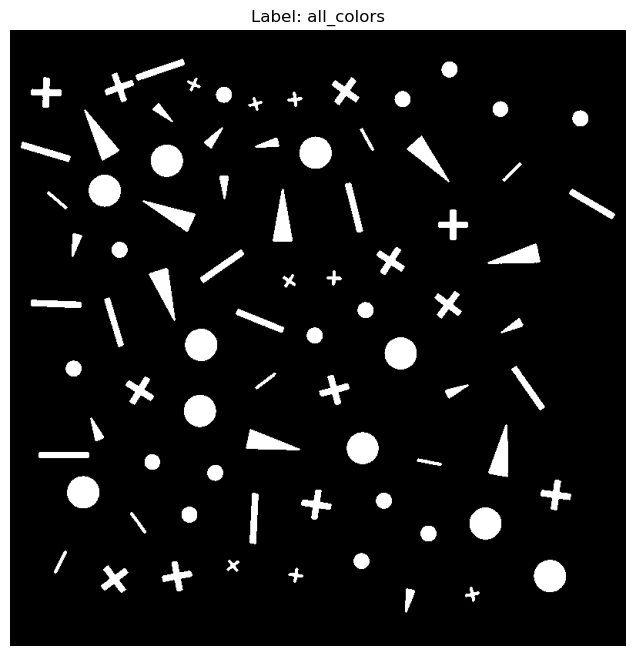

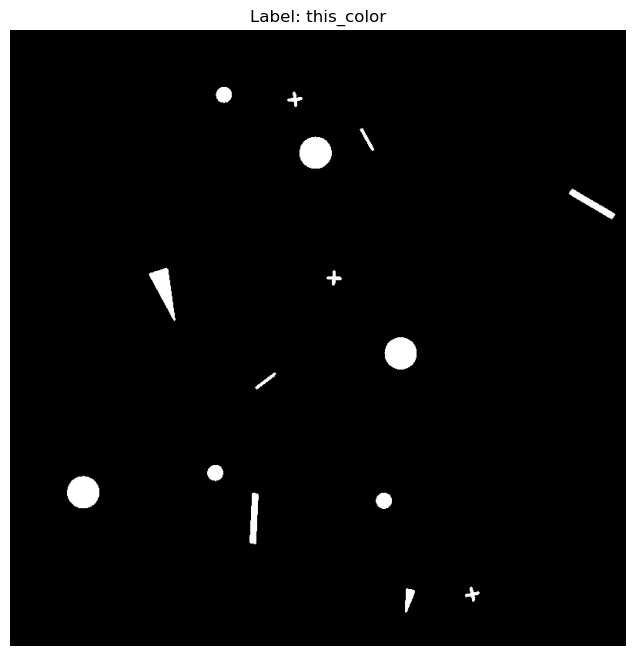

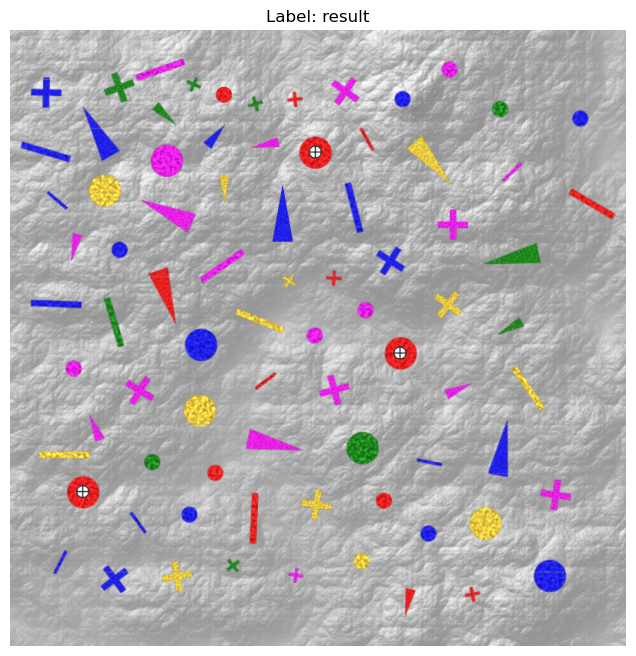

Located 3 large red circles


In [7]:

import numpy as np
import cv2 as cv
import os
from typing import Optional


SIZE_OPTIONS = ["large", "small"]
COLOR_OPTIONS = {
    "red": 0,       # 0° (Red starts at 0° and also at 180° for deeper red shades)
    "yellow": 30,   # ~30° (Yellow)
    "green": 60,    # ~60° (Green)
    "cyan": 90,     # ~90° (Cyan)
    "blue": 120,    # ~120° (Blue)
    "magenta": 150  # ~170° (Magenta/Pink)
}
SHAPE_OPTIONS = ["circle", "wedge", "rectangle", "cross"]


def otsu_threshold(counts: np.ndarray, bins: Optional[np.ndarray] = None) -> float:
    """Given a histogram (a numpy array where counts[i] is # of values where x=bins[i]) return
    the threshold that minimizes intra-class variance using Otsu's method. If 'bins' is provided,
    then the x-coordinate of counts[i] is set by bins[i]. Otherwise, it is assumed that the
    x-coordinates are 0, 1, 2, ..., len(counts)-1. If provided, 'bins' must be sorted in
    ascending order and have the same length as 'counts'.

    Note: For didactic purposes, this function uses numpy only and does not rely on OpenCV.
    """
    if bins is not None:
        if not len(counts) == len(bins):
            raise ValueError("bins must have the same length as counts")
        if not np.all(bins[:-1] <= bins[1:]):
            raise ValueError("bins must be sorted in ascending order")
    else:
        bins = np.arange(len(counts))

    def variance_helper(bins_: np.ndarray, counts_: np.ndarray) -> float:
        n = np.sum(counts_)
        if n == 0:
            return 0
        mu = np.dot(bins_, counts_) / n
        return np.dot(counts_, (bins_ - mu) ** 2) / n



    lowest_variance, best_threshold = float("inf"), 0
    for i in range(len(counts)):
        variance_left = variance_helper(bins[: i + 1], counts[: i + 1])
        variance_right = variance_helper(bins[i + 1 :], counts[i + 1 :])
        w_left, w_right = np.sum(counts[:i+1]), np.sum(counts[i+1:])
        total = w_left + w_right

        inter_class_variance = (w_left * variance_left + w_right * variance_right)/total # changed this to get left and right variance
        if inter_class_variance < lowest_variance:
            # Set the threshold to the midpoint between bins[i] and bins[i+1]
            th = (bins[i] + bins[i + 1]) / 2 if i < len(bins) - 1 else bins[i] + 0.5
            lowest_variance, best_threshold = inter_class_variance, th
    return best_threshold


def roundedness(moments: dict[str, float]) -> float:
    """Given the moments of a shape, return the roundedness of the shape. The roundedness is
    defined as the ratio of two second-moment axes to each other. The circle and cross shapes have
    a roundedness of close to 1, while the rectangle and wedge shapes have a roundedness less than 1

    Note: see the OpenCV docs for the difference between moments["mu20"] and moments["m20"]. The
    latter is in the lecture slides, but the former makes the calculation easier.
    https://docs.opencv.org/3.4/d8/d23/classcv_1_1Moments.html
    """
    covariance = np.array([[moments["mu20"], moments["mu11"]], [moments["mu11"], moments["mu02"]]])
    # The eigenvalues of the covariance matrix are the variances of the shape in the x and y
    # directions. The roundedness is the ratio of the smallest standard deviation to the largest.
    stdevs = np.sqrt(np.linalg.eigvalsh(covariance))
    return min(stdevs) / max(stdevs) # changed this to min/max from max/min


def threshold_on_hue(image: np.ndarray, color: str, hue_tolerance: int = 10) -> np.ndarray:
    """The job of this function is to convert the image to binary form, where the shapes of a
    particular color are 1 and the background is 0. By 'color' we mean that the hue of a pixel is
    equal to the hue named by the given color string, plus or minus hue_tolerance. This is done
    by thresholding the image, and applying some morphological operations to clean up the result.
    """

    # Convert to HSV
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Choose a saturation threshold using Otsu's method
    saturation_hist = cv.calcHist([hsv], [1], None, [256], [0, 256]).astype(np.int32).ravel()
    saturation_thresh = otsu_threshold(saturation_hist)

    # Threshold on hue and saturation
    range_lo = ((COLOR_OPTIONS[color] - hue_tolerance) % 180, saturation_thresh, 0)
    range_hi = ((COLOR_OPTIONS[color] + hue_tolerance) % 180, 255, 255)
    wrapped = COLOR_OPTIONS[color] - hue_tolerance < 0 or COLOR_OPTIONS[color] + hue_tolerance > 180

    # Handle the case where the hue range "wraps around" 180 by thresholding in two steps and
    # combining the results.
    if wrapped:
        binary = cv.inRange(hsv, range_lo, (180, *range_hi[1:]))
        binary |= cv.inRange(hsv, (0, *range_lo[1:]), range_hi)
    else:
        binary = cv.inRange(hsv, range_lo, range_hi)

    # Apply morphological operations to clean up the binary image
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    binary = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel)

    return binary


def is_shape_symmetric(
    binary: np.ndarray, centroid_xy: tuple[float, float], threshold: float
) -> bool:
    """Given a binary image, return True if the shape is symmetric about its centroid, and False
    otherwise. Symmetry is determined by checking if the shape is the same when rotated 180 degrees
    about its centroid. The threshold is the fraction of pixels that must match for the shape to be
    considered symmetric.
    """
    rot = cv.getRotationMatrix2D(centroid_xy, 180, 1) # changed the angle to 180, instead of pi
    flipped = cv.warpAffine(binary, rot, binary.shape)
    frac_match = np.sum(binary * flipped) / np.sum(binary)
    return frac_match > threshold


def sample_points_on_ring(
    binary: np.ndarray, center_xy: tuple[float, float], radius: float, num_points: int
) -> list:
    """'Sample' the given binary image at a ring of points around the given center with the given
    radius. Return a list of the values of the binary image at these points. If a point is outside
    the image, it is ignored.
    """
    locations_xy = [
        (center_xy[0] + radius * np.cos(theta), center_xy[1] + radius * np.sin(theta)) # changed it to use sin instead of cos
        for theta in np.linspace(0, 2 * np.pi, num_points + 1)
    ]
    return [
        binary[int(np.round(y)), int(np.round(x))]
        for x, y in locations_xy
        if 0 <= x < binary.shape[1] and 0 <= y < binary.shape[0]
    ]


def identify_single_shape(binary: np.ndarray) -> str:
    """Given a binary image that contains a single shape, return a string describing the shape, i.e.
    one of the SHAPE_OPTIONS shapes at the top of the file."""

    # Compute the moments of the shape and find its center of mass (AKA centroid)
    moments = cv.moments(binary)
    centroid_xy = (moments["m10"] / moments["m00"], moments["m01"] / moments["m00"])

    # First, we can distinguish between (rectangles and wedges) vs (circles and crosses) by looking
    # at the roundedness of the shape. If the roundedness is high, it's a circle or cross. If it's
    # low, it's a rectangle or wedge.
    roundness = roundedness(moments)
    
    if roundness < 0.7: # changed this from 0.5
        # If roundedness is low, it's a rectangle or wedge. We can distinguish between these two
        # by checking if the shape is symmetric about its centroid. If it is, it's a rectangle.
        # Otherwise, it's a wedge.
        if is_shape_symmetric(binary, centroid_xy, threshold=0.90): # changed threshold from 0.8
            return "rectangle"
        else:
            return "wedge"
    else:
        # Choose the radius of the ring so that it's not too big (all sampled points would be
        # outside the shape) and not too small (all sampled points would be 1s, even for the
        # cross). We can use the square root of the central second moment to estimate the
        # standard deviation or 'size' of the shape, and adjust the radius accordingly.
        stdev = np.sqrt(moments["mu20"] / moments["m00"])
        samples = sample_points_on_ring(binary, centroid_xy, radius= 0.9 * stdev, num_points=30) # used more points
        if np.all(samples):
            return "circle"
        else:
            return "cross"


def find_shapes(
    image: np.ndarray,
    size: str,
    color: str,
    shape: str,
    min_area: int = 3, # changed this from 10
    hue_tolerance: int = 10,
) -> np.ndarray:
    """Find all locations (centroids) in the image where there is a shape of the specified
    size, color, and shape type. Return the (x,y) locations of these centroids as a numpy array
    of shape (N, 2) where N is the number of shapes found.
    """
    # First pass: This gives ALL shapes that are saturated, effectively ignoring the hue
    binary_all_colors = threshold_on_hue(image, color, hue_tolerance=90)
    show_shape(binary_all_colors, "all_colors") # show all colors

    # Second pass: threshold the image using the specified hue tolerance to get a binary image with
    # just the color we're interested in.
    binary_this_color = threshold_on_hue(image, color, hue_tolerance=hue_tolerance)
    show_shape(binary_this_color, "this_color") # show this color

    # Use connected components to segment the binary image into individual shapes
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(binary_all_colors)

    # Loop over the identified connected components and identify their shape, size, and color.
    shape_info = []
    for i in range(num_labels): # iterate over all components/shapes
        # Skip if shape is too small (we can't identify very very small shapes))
        if i==0:
            continue
        if stats[i, cv.CC_STAT_AREA] < min_area:
            continue

        # Make a new temporary binary image with just the current shape
        shape_i_only = np.zeros_like(binary_this_color)
        shape_i_only[labels == i] = 1 # gets the intersection of the this component i and all_shapes_binary
        
        # Identify the shape
        shape_type = identify_single_shape(shape_i_only)

        # If it's the kind of shape we're looking for, record its location and size
        if shape_type == shape:
            area, is_correct_color = (
                stats[i, cv.CC_STAT_AREA],
                np.any(shape_i_only * binary_this_color),
            )
            shape_info.append((tuple(centroids[i]), area, is_correct_color))

    # Last, we need to filter out the shapes that are the wrong size.
    areas, counts = np.unique([area for _, area, _ in shape_info], return_counts=True)
    
    area_threshold = otsu_threshold(counts, areas) # fixed this to get thresh properly
    
    if size == "small":
        return np.array(
            [
                loc
                for loc, area, correct_color in shape_info
                if correct_color
                if area < area_threshold and correct_color
            ] 
        )
    else:
        return np.array(
            [
                loc
                for loc, area, correct_color in shape_info
                if correct_color
                if area >= area_threshold and correct_color
            ]
        )


def annotate_locations(image: np.ndarray, locs_xy: np.ndarray) -> np.ndarray:
    """Annotate the locations on the image by drawing circles on each (x,y) location"""
    annotated = image.copy()
    black, white, symbol_size = (0, 0, 0), (255, 255, 255), 8
    for x, y in locs_xy:
        x, y = int(x), int(y)
        cv.circle(annotated, (x, y), symbol_size, white, -1, cv.LINE_AA)
        cv.line(annotated, (x - symbol_size, y), (x + symbol_size, y), black, 1, cv.LINE_AA)
        cv.line(annotated, (x, y - symbol_size), (x, y + symbol_size), black, 1, cv.LINE_AA)
        cv.circle(annotated, (x, y), symbol_size, black, 1, cv.LINE_AA)
    return annotated


import matplotlib.pyplot as plt
# helper function, because I use headless opencv
def show_shape(shape_i_only, i, figsize=(8, 8)):  # Default to 8x8 inches
    """Displays the image with only the pixels of shape i and prints the label."""
    if len(shape_i_only.shape) == 3:  # Check if the image has 3 channels
        shape_i_only = cv.cvtColor(shape_i_only, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.figure(figsize=figsize)  # Set the figure size
    plt.imshow(shape_i_only, cmap='gray' if len(shape_i_only.shape) == 2 else None)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.title(f"Label: {i}")
    plt.show()

def main(image_path: str, size: str, color: str, shape: str, min_area: int = 10, hue_tolerance: int = 10):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File not found: {image_path}")

    # Load the image
    im = cv.imread(image_path)
    
    # Find the shapes
    locations = find_shapes(im, size, color, shape, min_area=min_area, hue_tolerance=hue_tolerance)
    description = f"Located {len(locations)} {size} {color} {shape}s"

    # Annotate the locations on the image
    annotated_image = annotate_locations(im, locations)

    # cv2_imshow(annotated_image)
    show_shape(annotated_image, "result")
    print(description)


# Example usage
image_path = 'shapes.png'  # Replace with your image path
size = 'small'  # or 'small'
color = 'red'  # or any color from COLOR_OPTIONS
shape = 'circle'  # or 'wedge', 'rectangle', 'cross'
main('shapes.png', 'large', 'red', 'circle', min_area=10, hue_tolerance=10)


# main(image_path, size, color, shape) # my functino to run program without arguments


# if __name__ == "__main__":
#     import argparse

#     parser = argparse.ArgumentParser()
#     parser.add_argument("image", help="Path to the image file")
#     parser.add_argument("size", help="Return large or small shapes?", choices=SIZE_OPTIONS)
#     parser.add_argument(
#         "color", help="Return shapes of a specific color?", choices=COLOR_OPTIONS.keys()
#     )
#     parser.add_argument("shape", help="Return shapes of a specific type?", choices=SHAPE_OPTIONS)
#     parser.add_argument("--min-area", type=int, default=10, help="Minimum area of a shape")
#     parser.add_argument("--hue-tolerance", type=int, default=10, help="Hue tolerance")
#     args = parser.parse_args()

#     if not os.path.exists(args.image):
#         raise FileNotFoundError(f"File not found: {args.image}")

#     # Load the image
#     im = cv.imread(args.image)

#     # Find the shapes
#     locations = find_shapes(
#         im,
#         args.size,
#         args.color,
#         args.shape,
#         min_area=args.min_area,
#         hue_tolerance=args.hue_tolerance,
#     )
#     description = f"Located {len(locations)} {args.size} {args.color} {args.shape}s"

#     # Annotate the locations on the image and display it
#     cv.imshow(description, annotate_locations(im, locations))
#     cv.waitKey(0)
#     cv.destroyAllWindows()

# # python3 ./shape_finder.py shapes.png large red circle

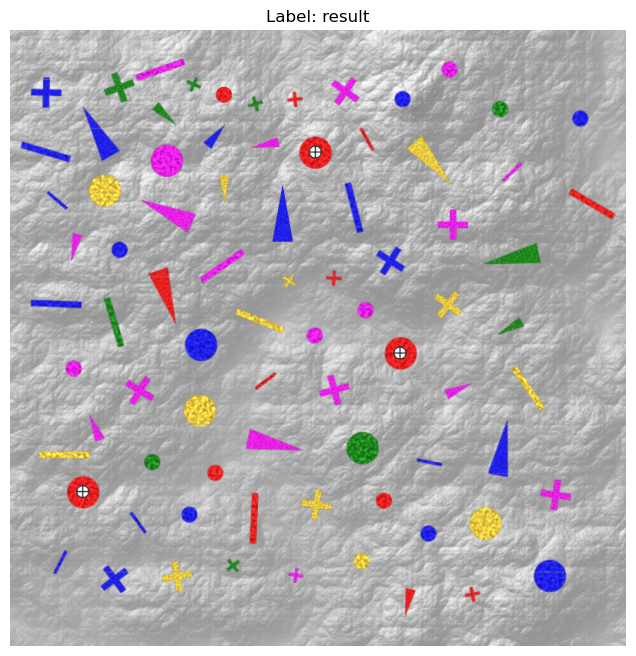

Located 3 large red circles
